## Installations and Imports :



In [ ]:
!pip install sklearn librosa tensorflow mir_eval

In [ ]:
#!/usr/bin/env python3
import argparse

from numpy.lib.npyio import save
from Models import MLP, MLP_scalered, CRNN, CRNN_1, MLP2RNN, CRNN_2, BassVsThird
from Datasets import IsophonicsDataset
from SegmentationModels import SegmentationCRNN, EncoderDecoderSegmentation, colorize_spectrograms, chord_graphical_segmentations 
import sklearn
import sys

In [ ]:
#!/usr/bin/env python3
parser = argparse.ArgumentParser()
# Directories, destinations, folders, files
parser.add_argument("--isophonics_audio_directory", default="./Datasets/Isophonics/AUDIO", type=str, help="Path to ISOPHONICS directory with audio files.")
parser.add_argument("--isophonics_annotations_directory", default="./Datasets/Isophonics/ANNOTATIONS", type=str, help="Path to ISOPHONICS directory with chord annotations.")
parser.add_argument("--billboard_audio_directory", default="./Datasets/Billboard/AUDIO", type=str, help="Path to BILLBOARD directory with audio files.")
parser.add_argument("--billboard_annotations_directory", default="./Datasets/Billboard/ANNOTATIONS", type=str, help="Path to BILLBOARD directory with chord annotations.")
parser.add_argument("--isophonics_prep_dest", default="./PreprocessedDatasets/isophonics_new.ds", type=str, help="Preprocessed ISOPHONICS dataset destination.")
parser.add_argument("--billboard_prep_dest", default="./PreprocessedDatasets/billboard_new.ds", type=str, help="Preprocessed BILLBOARD dataset destination.")

# Dataset preprocessing args
parser.add_argument("--dataset", default="isophonics", type=str, help="Dataset we want to preprocess, {isophonics, billboard}")
#           Isophonics
parser.add_argument("--sample_rate", default=44100, type=int, help="Sample rate for each song.")
parser.add_argument("--hop_length", default=512, type=int, help="10*(sample_rate/hop_length) is a number of miliseconds between two frames.")
parser.add_argument("--window_size", default=8, type=int, help="Spectrograms on left, and also spectrogram on right of the time bin -> window_size*2 + 1 spectrograms grouped together.")
parser.add_argument("--flattened_window", default=False, type=bool, help="Whether the spectrogram window should be flatten to one array or it sould be array of spectrograms.")
parser.add_argument("--ms_intervals", default=430.6640625, type=float, help="Miliseconds between generated spectrograms.")
parser.add_argument("--to_skip", default=10, type=int, help="How many spectrogram we want to skip when creating spectrogram window.")
parser.add_argument("--norm_to_C", default=True, type=bool, help="Whether we want to transpose all songs to C key (or D dorian, .. A minor, ...)")
parser.add_argument("--spectrogram_type", default="cqt", type=str, help="Spectrogram types, {cqt,log_mel}")
#           Billboard
parser.add_argument("--n_frames", default=1000, type=int, help="Length of song subsequence we are consinder when predicting chords to keep some context.")

# Training args
parser.add_argument("--test_size", default=0.3, type=lambda x:int(x) if x.isdigit() else float(x), help="Test set size.")
parser.add_argument("--epochs", default=100, type=int, help="Number of epochs.")
parser.add_argument("--seed", default=42, type=int, help="Random seed.")


args = parser.parse_args([] if "__file__" not in globals() else None)

# ISOPHONICS DATASET

## Beat tracking, Tempo, BPM
*Using LIBORSA library*

In [ ]:
import librosa
# Load audio
y, sr = librosa.load('A Kind Of Magic.wav')
# Get tempo and beats
tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
# Print tempo and sample beats
print("A KIND OF MAGIC song by QUEEN")
print(" Tempo: ", tempo)
print(" Beats: ", beats[0:10], " ... ", beats[250:260], " ... ", beats[-11:-1])

A KIND OF MAGIC song by QUEEN
 Tempo:  129.19921875
 Beats:  [ 48  67  87 107 126 146 166 186 206 225]  ...  [5010 5030 5050 5069 5089 5109 5129 5149 5169 5188]  ...  [10946 10966 10986 11006 11025 11045 11065 11085 11105 11125]


A KIND OF MAGIC song by QUEEN



[Text(0.5, 1.0, 'Tempogram')]

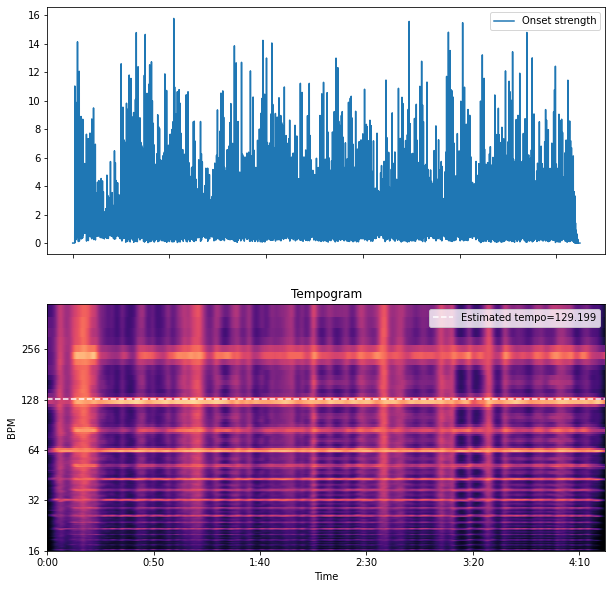

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
import librosa

# Load audio
y, sr = librosa.load('A Kind Of Magic.wav')
print("A KIND OF MAGIC song by QUEEN\n")

# GENERATE, onset_strength, tempogram, tempo
oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=512)
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr, hop_length=512)
# Compute global onset autocorrelation
ac_global = librosa.autocorrelate(oenv, max_size=tempogram.shape[0])
ac_global = librosa.util.normalize(ac_global)
# Estimate the global tempo for display purposes
tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr, hop_length=512)[0]

# DISPLAY, onset_strength, tempogram, tempo

# Plot Onset strength
fig, ax = plt.subplots(nrows=2, figsize=(10, 10))
times = librosa.times_like(oenv, sr=sr, hop_length=512)
ax[0].plot(times, oenv, label='Onset strength')
ax[0].label_outer()
ax[0].legend(frameon=True)

# Plot Tempogram with tempo
librosa.display.specshow(tempogram, sr=sr, hop_length=512,
                         x_axis='time', y_axis='tempo', cmap='magma',
                         ax=ax[1])
ax[1].axhline(tempo, color='w', linestyle='--', alpha=1,
            label='Estimated tempo={:g}'.format(tempo))
ax[1].legend(loc='upper right')
ax[1].set(title='Tempogram')

## Harmony Segmentation

### Data representation


#### For an encoder-decoder model
  - Input : Spectrogram sequences
  - Output : Chord changes graph


Populating the interactive namespace from numpy and matplotlib
[INFO] The Isophonics segmentation samples was loaded successfully.
(12, 1000, 252)


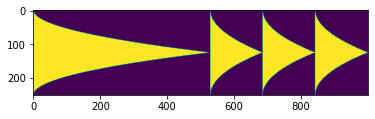

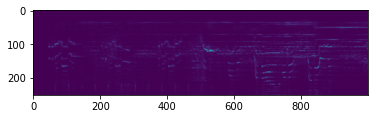

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


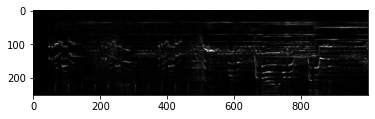

In [ ]:
import numpy as np
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

data, chord_list, chord_changes_list = IsophonicsDataset.load_segmentation_samples("./PreprocessedDatasets/Isophonics1000.seg")

segmentation = np.array(chord_graphical_segmentations((1000, 252), chord_list[0]))
print(segmentation.shape)
plt.imshow(segmentation[0].T)
plt.show()

plt.imshow(data[0][0].T)
plt.show()
rgb_batch = colorize_spectrograms(np.array(data[0]))
plt.imshow(rgb_batch[0])
plt.show()

#### For a CRNN model
  - Input : Spectrogram sequences
  - Output : Sequences of zeros and ones, 0 ~ no chord change, 1 chord change

```[C,C,C,C,C,C,C,C,C,D,D,D,D,D,D,D,D,D,D,G,...]```
to 
```[0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,...]```

### Results


#### EncoderDecoder model results

In [ ]:
# Preprocess dataset
import tensorflow
# Prepare data
x, y = IsophonicsDataset.load_preprocessed_dataset("./PreprocessedDatasets/Isophonics50_log_mel.ds")
n_samples, n_frames, n_features = x.shape
x = colorize_spectrograms(np.array(x), 1, False)
y = np.repeat(np.array(chord_graphical_segmentations((48, 128), y))[..., np.newaxis], 1, -1)
print(x.shape, y.shape)

train_x, dev_x, train_y, dev_y = sklearn.model_selection.train_test_split(x, y, test_size=0.3, random_state=args.seed)



# Create model
seg_model = EncoderDecoderSegmentation((50,128,1))

# Train model
seg_model.fit(train_x, train_y, dev_x, dev_y, epochs=88)
 


[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
(1679, 50, 128, 1) (1679, 48, 128, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 50, 128, 64)       640       
_________________________________________________________________
batch_normalization_16 (Batc (None, 50, 128, 64)       256       
_________________________________________________________________
activation_18 (Activation)   (None, 50, 128, 64)       0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 25, 64, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 25, 64, 128)       73856     
_________________________________________________________________
batch_normalization_17 (Batc (None, 25, 64, 128)       512       
______________

Populating the interactive namespace from numpy and matplotlib


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(504, 48, 128, 3)
----- NEW SAMPLE -----


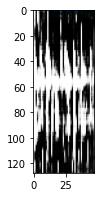

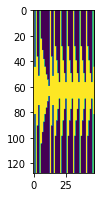

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


----- NEW SAMPLE -----


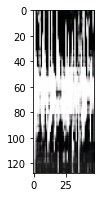

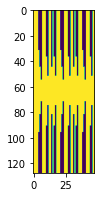

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


----- NEW SAMPLE -----


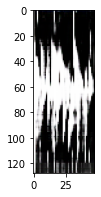

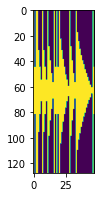

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


----- NEW SAMPLE -----


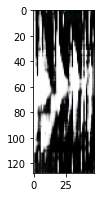

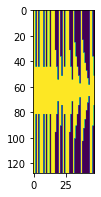

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


----- NEW SAMPLE -----


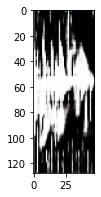

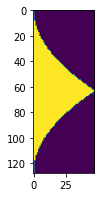

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

predictions = seg_model.predict(dev_x)
gold = dev_y
print(predictions.shape)

for pred, target in zip(predictions[350:355], gold[350:355]):
    print("----- NEW SAMPLE -----")
    plt.imshow(pred.swapaxes(0,1))
    plt.show()
    plt.imshow(np.squeeze(target).T)
    plt.show()


#### CRNN model results

*NLLS chromas have higher accuracy, but still the model predicts primarly zeros -> the segmentation result is useless*

[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 100, 128, 16)      160       
_________________________________________________________________
batch_normalization_10 (Batc (None, 100, 128, 16)      64        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 100, 128, 16)      2320      
_________________________________________________________________
batch_normalization_11 (Batc (None, 100, 128, 16)      64        
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 100, 128, 16)      2320      
_________________________________________________________________
batch_normalization_12 (Batc (None, 100, 128, 16)      64        
____________________________________________________

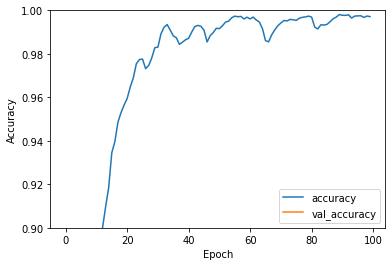

9/9 - 2s - loss: 1.3309 - accuracy: 0.7904

 Dev accuracy:  79.04 % 



In [ ]:
#!/usr/bin/env python3
# Prepare data
x, y = IsophonicsDataset.load_preprocessed_dataset("./PreprocessedDatasets/Isophonics100_log_mel.ds")
n_samples, n_frames, n_features = x.shape
x = x.reshape((n_samples,n_frames,n_features,1))
train_x, dev_x, train_y, dev_y = sklearn.model_selection.train_test_split(x, y, test_size=0.3, random_state=args.seed)

# Preprocess data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_samples, train_frames, train_features, _ = train_x.shape 
dev_samples, dev_frames, dev_features, _ = dev_x.shape

# Train Scaler
scaler.fit(train_x.reshape(train_samples, train_frames*train_features))
# Transpose 
train_x = scaler.transform(train_x.reshape(train_samples, train_frames*train_features)).reshape((train_samples, train_frames, train_features, 1))
dev_x = scaler.transform(dev_x.reshape(dev_samples, dev_frames*dev_features)).reshape((dev_samples, dev_frames, dev_features, 1))

# Create model
seg_model = SegmentationCRNN(input_shape=(n_frames, n_features, 1))
 
# Train model
seg_model.fit(train_x, train_y, dev_x, dev_y, epochs=100)
 
# Display score
seg_model.display_training_progress()
print("\n","Dev accuracy: ", "{:.2f}".format(100*seg_model.score(dev_x, dev_y)), "%", "\n")
